In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.distributions import Beta, Gamma, MultivariateNormal

import sbibm

from sbi.inference import MNLE
from sbi.utils import process_prior, likelihood_nn
from sbi.analysis import pairplot

In [2]:
task = sbibm.get_task("ddm")
simulator = task.get_simulator()

In [17]:
proposal, *_ = process_prior([
    MultivariateNormal(torch.zeros(1), torch.eye(1)), 
    Gamma(torch.tensor([8.]), torch.tensor([7.0])),
    Beta(torch.tensor([4.]), torch.tensor([4.])),
    Gamma(torch.tensor([2.]), torch.tensor([2.0])),
    ])

/home/janfb/qode/sbi/sbi/utils/user_input_checks.py:67: UserWarning: Prior was provided as a sequence of 4 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  components of the parameter."""


/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


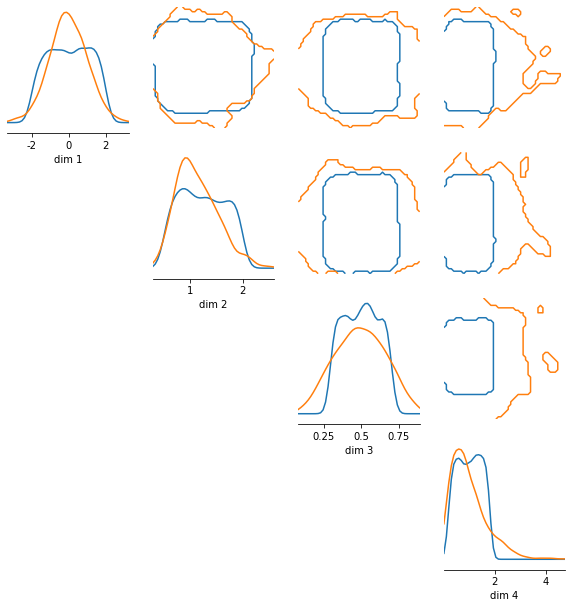

In [19]:
# compare prior and proposal distributions.
pairplot([task.prior_dist.sample((1000,)), proposal.sample((1000,))], 
    upper="contour", 
    diag="kde",
    contour_offdiag=dict(levels=[.99]));

In [20]:
n = 100_000
theta_proposal = proposal.sample((n,))
x_1d = simulator(theta_proposal)

# encode x as (time, choice)
x_proposal = torch.zeros((x_1d.shape[0], 2))
x_proposal[:, 0] = abs(x_1d[:, 0])
x_proposal[x_1d[:, 0] > 0, 1] = 1
x_proposal.shape

/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


torch.Size([100000, 2])

In [21]:
mnle_provider = likelihood_nn(
    model = "mnle",
    **dict(
        log_transform_x = False,
        num_bins = 5,
        num_transforms = 2, 
        tail_bound = 10.0, 
        hidden_layers = 1,
        hidden_features = 10,
    ))
batch_size = 100
stop_after_epochs = 30

## Train MNLE with once with data from prior, and once with data from proposal

In [22]:
# proposal
trainer = MNLE(density_estimator = mnle_provider)
estimator_proposal = trainer.append_simulations(theta_proposal, x_proposal).train(
                training_batch_size=batch_size, 
                stop_after_epochs=stop_after_epochs)

/home/janfb/qode/sbi/sbi/neural_nets/mnle.py:64: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  this is not the case for the passed `x` do not use this function."""


 Neural network successfully converged after 132 epochs.

In [24]:
# prior
import pickle
from pathlib import Path 
budget = "100000"
model_path = Path.cwd() / f"models/"
init_idx = 5
network_file_path = list(model_path.glob(f"mnle_n{budget}_new*"))[init_idx]  # take one model from random inits.

with open(network_file_path, "rb") as fh:
    estimator_prior, *_ = pickle.load(fh).values()
# estimator_prior = trainer.append_simulations(theta_prior, x_prior).train(
#                 training_batch_size=batch_size, 
#                 stop_after_epochs=stop_after_epochs)

In [25]:
# run inference with VI
num_samples = 1000

# get test xo
obs_idx = 201  # 100-trials iid observation.
xo_1d = task.get_observation(obs_idx).T
theta_o = task.get_true_parameters(obs_idx)
reference_samples = task.get_reference_posterior_samples(obs_idx)

xo = torch.zeros((xo_1d.shape[0], 2))
xo[:, 0] = abs(xo_1d[:, 0])
xo[xo_1d[:, 0] > 0, 1] = 1

In [26]:
viposterior = MNLE().build_posterior(estimator_proposal, task.prior_dist, 
    sample_with="vi"
    )
viposterior.set_default_x(xo)
viposterior.train()
vi_samples_proposal = viposterior.sample((num_samples, ))

viposterior = MNLE().build_posterior(estimator_prior, task.prior_dist, 
    sample_with="vi"
    )
viposterior.set_default_x(xo)
viposterior.train()
vi_samples_prior = viposterior.sample((num_samples, ))

/home/janfb/qode/sbi/sbi/utils/sbiutils.py:282: UserWarning: An x with a batch size of 100 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""


  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: 107.75
Quality Score: 0.097 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: 107.86
Quality Score: -0.004 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


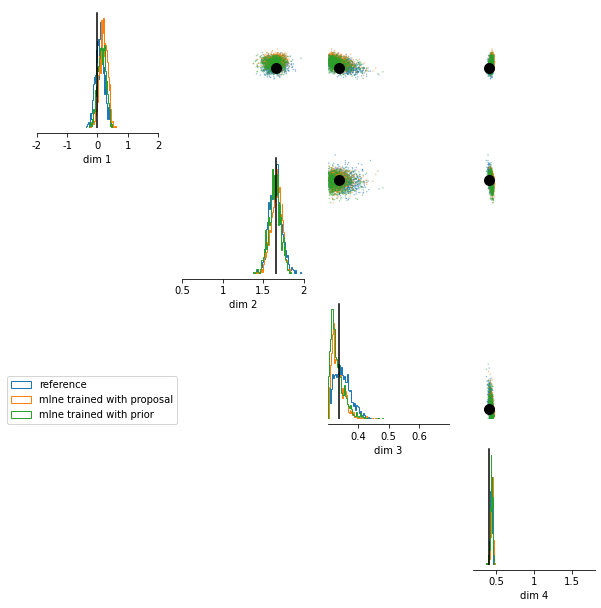

In [27]:
# compare prior and proposal distributions.
fig, ax = pairplot([reference_samples[:num_samples], vi_samples_proposal, vi_samples_prior], 
    upper="scatter", 
    points = theta_o,
    limits=[[-2, 2], [.5, 2], [.3, .7], [0.2, 1.8]],
    points_colors=["k"],
    scatter_offdiag=dict(alpha=0.5, s=2));
plt.sca(ax[0, 0])
plt.legend(["reference", "mlne trained with proposal", "mlne trained with prior"], bbox_to_anchor=(1.2, -2))

In [28]:
from sbi.utils.metrics import c2st

c2st(reference_samples[:num_samples], vi_samples_prior)

tensor([0.6340])

In [29]:
c2st(reference_samples[:num_samples], vi_samples_proposal)

tensor([0.7285])

In [30]:
c2st(vi_samples_prior, vi_samples_proposal)

tensor([0.6380])